# Livrable 1 - groupe 1

Nous sommes le groupe 1 composé de :  
- DELORME Alexandre
- ENCOGNERE Yanis
- MENNERON Laurine
- PEREON Alexandre
- ROCHARD Léo


# TODO

##  Analyse des Résultats et Biais/VarianceAnalyse

Discussion sur le surapprentissage/sous-apprentissage

Calcul et affichage d'une matrice de confusion

Calcul de métriques supplémentaires (précision, rappel, F1-score)

## À implémenter/discuter:

Régularisation L2 dans les couches denses/convolutionnelles

Ajustement du taux de dropout

Utilisation de Batch Normalization

Transfer learning avec un modèle pré-entraîné (VGG16, ResNet, etc.)

Grid search pour optimiser les hyperparamètres

## Documentation et Justifications

Schéma de l'architecture du réseau (peut être généré avec tf.keras.utils.plot_model)

Justification des choix (architecture, hyperparamètres, etc.)

Analyse des résultats obtenus

Discussion sur les difficultés rencontrées (images réalistes dans les peintures)

## Gestion des Données Déséquilibrées

Analyse du déséquilibre entre classes photo/non-photo

Techniques pour gérer le déséquilibre (poids de classe, oversampling, etc.)

### Chargement des bibliothèques

In [1]:
%load_ext tensorboard
import os
import pathlib
import zipfile
from datetime import datetime

import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import visualkeras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

### Chargement du dataset


Cette partie permet de récuperer le dataset depuis le drive afin d'automatiser la pipeline. L'objectif est d'utiliser un dataset commun au sein du groupe. 

Ce dernier à le dossier "Sketch" complété par des données trouvés dans les sources suivantes : [croquis](https://paperswithcode.com/dataset/sketch) || [visages réalistes](https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs/data)

Ce qui fait passer le dossier sketch de 606 visages et 800 croquis avec un ration de 43%/57% entre visages/croquis à 1200 visages et 3200 croquis pour un ratio final équivalent.

In [2]:
# ID du fichier (extrait de l'URL)
file_id = "1d0k3mXd93JM0fLLYrUZRr4Un1F_TnuHi"
dataset_path = "dataset_livrable_1"
zip_path = dataset_path + ".zip"
extract_dir = pathlib.Path(zip_path).parent / dataset_path
reduce_dataset = True

if not os.path.exists(extract_dir):
    print(f"Le dossier '{extract_dir}' n'existe pas. Téléchargement en cours...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

    print(f"Extraction ZIP en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction Zip terminée")
else:
    print(f"Le dossier '{extract_dir}' existe déjà. Téléchargement et extraction non nécessaires.")

data_dir = extract_dir
print(f"Dataset disponible dans : {data_dir}")

Le dossier 'dataset_livrable_1' existe déjà. Téléchargement et extraction non nécessaires.
Dataset disponible dans : dataset_livrable_1


### Détection des catégories

In [3]:
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Catégories détectées : {categories}")

Catégories détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Pré traitement des images

In [ ]:
# Suppresion des fichiers corrompus ou non images --------------------------------------------------------------------
def clean_images_dataset(dataset_path_arg):
    """
    Fonction pour nettoyer le dataset en supprimant les fichiers corrompus ou non images.
    """
    # Dictionnaire pour stocker le nombre d'images corrompues par classe
    corrupted_count_by_class = defaultdict(int)
    dataset_path = dataset_path_arg
    print("Début de la vérification des images ...")

    # Récupération de toutes les images pour calculer la progression
    all_files = []
    for dir_name in os.listdir(dataset_path):
        dir_path = os.path.join(dataset_path, dir_name)
        for file_name in os.listdir(dir_path):
            all_files.append((dir_name, dir_path, file_name))

    total_files = len(all_files)
    checked_files = 0  # Pour la progression

    # Parcours des images avec affichage de la progression
    for dir_name, dir_path, file_name in all_files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with open(os.path.join(dir_path, file_name), 'rb') as file:
                    img_bytes = file.read()  # Lire les bytes de l'image
                    img = tf.image.decode_image(img_bytes)  # Essayer de décoder l'image
            except Exception as e:
                corrupted_count_by_class[dir_name] += 1
                print(f"\nImage corrompue : {file_name} dans {dir_name}. Exception: {e}")
                os.remove(os.path.join(dir_path, file_name))
                print(f"Image {file_name} supprimée.")
        else:
            corrupted_count_by_class[dir_name] += 1
            print(f"\nLe fichier {file_name} dans {dir_name} n'est pas une image.")
            os.remove(os.path.join(dir_path, file_name))
            print(f"Fichier {file_name} supprimé.")

        # Mise à jour de la progression
        checked_files += 1
        progress = (checked_files / total_files) * 100
        print(f"\rProgression : [{int(progress)}%] {checked_files}/{total_files} images vérifiées", end="")

    print("\nVérification des fichiers terminée.")

    # Affichage du nombre d'images corrompues par dossier
    for dir_name, count in corrupted_count_by_class.items():
        print(f"Dossier {dir_name} : {count} images corrompues")

    # Nombre total d'images corrompues
    total_corrupted = sum(corrupted_count_by_class.values())
    print(f"Nombre total d'images corrompues ou non image : {total_corrupted}")

### Calcul du nombre de données par classe

In [4]:
class_counts = {class_name: len(list((data_dir / class_name).glob('*'))) for class_name in categories}
class_counts['Sketch'] = len(list((data_dir / 'Sketch' / 'jpg').glob('*'))) + len(
    list((data_dir / 'Sketch' / 'png').glob('*')))
print(class_counts)

{'Painting': 9999, 'Photo': 9993, 'Schematics': 10000, 'Sketch': 4394, 'Text': 10000}


### Chargement des images

In [5]:
validation_split = 0.2
seed = 42
batch_size = 32
img_height = 180
img_width = 180

train_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

val_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=categories)

class_names = train_set.class_names
num_classes = len(class_names)

print(f"Classes found: {class_names}")

Found 44386 files belonging to 5 classes.
Using 35509 files for training.
Found 44386 files belonging to 5 classes.
Using 8877 files for validation.
Classes found: ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Visualisation des différentes classes

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Répartition des classes au sein du dataset

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Repartition")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

### Préparation pour analyse


In [ ]:
# Convertir les images et labels en arrays
images, labels = zip(*[(image_batch.numpy(), label_batch.numpy()) for image_batch, label_batch in train_set])
images = np.concatenate(images)
labels = np.concatenate(labels)

# Sélectionner 20% des données aléatoirement
num_samples = images.shape[0]
sample_size = int(num_samples * 0.20)  # 20% du dataset
indices = np.random.choice(num_samples, sample_size, replace=False)

# Extraire les échantillons sélectionnés
images_sampled = images[indices]
labels_sampled = labels[indices]

### Analyse en composantes principales


In [ ]:
# Réduction dimensionnelle avec PCA
images_reshaped = images_sampled.reshape(images_sampled.shape[0], -1)
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(images_reshaped)

# Affichage PCA
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.scatter(pca_result[labels_sampled == i, 0], pca_result[labels_sampled == i, 1], label=class_names[i], alpha=0.4)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Plot of Image Data")
plt.legend()
plt.show()

In [ ]:
x_min = np.round(pca_result[:, 0].min(), -4)
x_max = np.round(pca_result[:, 0].max(), -4)
y_min = np.round(pca_result[:, 1].min(), -4)
y_max = np.round(pca_result[:, 1].max(), -4)

# Créer des subplots avec 2 lignes et 3 colonnes (ajuster en fonction du nombre de classes)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Aplatir la matrice d'axes pour un accès facile

# Affichage de PCA pour chaque classe dans un subplot distinct
for i in range(len(class_names)):
    ax = axes[i]  # Sélectionner l'axe pour la classe i

    # Filtrer les points de la classe i
    ax.scatter(pca_result[labels_sampled == i, 0], pca_result[labels_sampled == i, 1],
               alpha=0.6, label=f"{class_names[i]}", color=f"C{i}")

    # Définir les mêmes limites globales pour tous les subplots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title(f"PCA Scatter Plot for {class_names[i]}")
    ax.legend()

# Supprimer les axes inutilisés si le nombre de classes est inférieur au nombre de subplots
for j in range(len(class_names), len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espace entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()

### Interprétation des résultats

Ce graphique divise l'espace PCA en différentes sous-graphiques pour analyser la distribution individuelle de chaque catégorie.

Peinture (Painting) : Distribuée assez largement, avec des valeurs de PCA couvrant une large plage. Cela suggère une diversité importante dans les caractéristiques des peintures, rendant difficile une séparation nette.

Photo : Également bien dispersée, mais plus concentrée autour d'un noyau central, indiquant que les photos partagent plus de caractéristiques communes que les peintures.

Schéma (Schematics) : La distribution est plus linéaire, suggérant que les caractéristiques des schémas sont fortement corrélées à une dimension spécifique de la PCA.

Croquis (Sketch) : Cette catégorie semble former un cluster compact, mais décalé par rapport aux autres types d'images, suggérant qu'elle est relativement distincte dans l'espace des caractéristiques.

Texte : Très fortement regroupé dans une zone précise, ce qui confirme que les images de texte ont des caractéristiques très spécifiques et homogènes.

### Analyse TSNE


In [ ]:
# Réduction dimensionnelle avec t-SNE
tsne = TSNE(n_components=2, random_state=123)
tsne_result = tsne.fit_transform(images_reshaped)

# Affichage t-SNE
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(labels_sampled))):
    plt.scatter(tsne_result[labels_sampled == i, 0], tsne_result[labels_sampled == i, 1], label=f"{class_names[i]}",
                alpha=0.4)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("2D t-SNE Visualization of Image Data")
plt.legend()
plt.show()


In [ ]:
# Déterminer les limites globales des axes pour t-SNE
x_min, x_max = tsne_result[:, 0].min(), tsne_result[:, 0].max()
y_min, y_max = tsne_result[:, 1].min(), tsne_result[:, 1].max()

# Créer des subplots avec 2 lignes et 3 colonnes (tu peux ajuster en fonction du nombre de classes)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Aplatir pour faciliter l'accès aux axes

# Nombre de classes
num_classes = len(np.unique(labels_sampled))

# Affichage de t-SNE pour chaque classe dans un subplot distinct
for i in range(num_classes):
    ax = axes[i]  # Sélectionner l'axe pour la classe i

    # Filtrer les points de la classe i
    ax.scatter(tsne_result[labels_sampled == i, 0], tsne_result[labels_sampled == i, 1],
               alpha=0.6, label=f"{class_names[i]}", color=f"C{i}")

    # Définir les mêmes limites globales pour tous les subplots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_title(f"t-SNE for {class_names[i]}")
    ax.legend()

# Supprimer les axes inutilisés si le nombre de classes est inférieur au nombre de subplots
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espace entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()

### Interprétation des résultats

PrenomNom — 14:09
Painting (bleu) et Photo (orange) : Très imbriquées, ce qui suggère que leurs caractéristiques sont proches dans l’espace des features. Cela peut s'expliquer par une similarité visuelle ou une proximité stylistique entre certains tableaux et photos réalistes.

Schematics (vert clair) : Bien qu’elles s’étendent sur une large zone, elles forment une structure allongée partiellement chevauchée avec les clusters Painting/Photo. Cela indique une diversité interne importante dans cette classe, mais aussi quelques similarités avec des photos/peintures (probablement des schémas techniques complexes).

Sketch (rouge) : Très bien séparées, formant un cluster compact et isolé en haut de la carte. Cela montre que les croquis possèdent des caractéristiques visuelles très distinctes (formes simples, contours marqués, peu de textures).

Text (violet) : Regroupé de manière très dense et distincte à droite, formant plusieurs sous-clusters. Cela peut indiquer différents styles de textes (manuscrits, imprimés, tapés), mais reste bien séparé des autres types d’images, ce qui est cohérent avec la nature très différente du contenu textuel.

## Modélisation

### Optimisation pour l'entrainement

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Cette commande n'est pas nécessaire sur colab
train_set = train_set.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.prefetch(buffer_size=AUTOTUNE)

### Définition de la fonction de perte

In [14]:
total = sum(class_counts.values())
weights = {class_name: (total / class_count) for class_name, class_count in class_counts.items()}

max_weight = max(weights.values())
class_weights = {class_name: weight / max_weight for class_name, weight in weights.items()}

print("Class Weights:", class_weights)

# Appliquer les poids dans la fonction de perte
class_weight_tensor = tf.constant([class_weights[class_name] for class_name in categories], dtype=tf.float32)

print("Class_weight_tensor:", class_weight_tensor)


@tf.keras.utils.register_keras_serializable()
def weighted_loss(y_true, y_pred):
    weights = tf.gather(class_weight_tensor, tf.cast(y_true, tf.int32))
    unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return unweighted_loss * weights

Class Weights: {'Painting': 0.4394439443944394, 'Photo': 0.4397077954568198, 'Schematics': 0.4394, 'Sketch': 1.0, 'Text': 0.4394}
Class_weight_tensor: tf.Tensor([0.43944395 0.4397078  0.4394     1.         0.4394    ], shape=(5,), dtype=float32)


### Définition du modèle

In [65]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.1, seed=42),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'), ]
)

model.compile(optimizer='adam', loss=weighted_loss, metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Visualisation du modèle

In [ ]:
visualkeras.layered_view(model, legend=True)

### Entrainement

#### Définition des callbacks

In [66]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./L1_model.keras', save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### Fit

In [ ]:
epochs = 10

history = model.fit(train_set,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_set,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 182s 163ms/step - accuracy: 0.4301 - loss: 2.6004 - val_accuracy: 0.6850 - val_loss: 0.3715
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 180s 162ms/step - accuracy: 0.6978 - loss: 0.3472 - val_accuracy: 0.7775 - val_loss: 0.2488
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 182s 164ms/step - accuracy: 0.7829 - loss: 0.2364 - val_accuracy: 0.7525 - val_loss: 0.2762
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 182s 164ms/step - accuracy: 0.8105 - loss: 0.2050 - val_accuracy: 0.8355 - val_loss: 0.1878
Epoch 5/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 181s 163ms/step - accuracy: 0.8014 - loss: 0.2398 - val_accuracy: 0.8459 - val_loss: 0.1734
Epoch 6/10
 684/1110 ━━━━━━━━━━━━━━━━━━━━ 3:25 483ms/step - accuracy: 0.8494 - loss: 0.1614

In [48]:
%tensorboard --logdir logs/fit

In [15]:
model = load_model('L1_model.keras')

### Matrice de confusion et rapport de classification

In [16]:
def confusion_matrix_and_report(model, val_set, class_names):
    print("Classes utilisées :", class_names)

    # Préparer les données de validation sans modification
    val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Obtenir les vraies étiquettes et les prédictions
    val_true_labels = []
    val_pred_labels = []

    for images, labels in val_set:
        # Prédictions pour le batch
        predictions = model.predict(images, verbose=0)
        val_pred_labels.extend(np.argmax(predictions, axis=1))
        val_true_labels.extend(labels.numpy())

    # Convertir en arrays numpy
    val_true_labels = np.array(val_true_labels)
    val_pred_labels = np.array(val_pred_labels)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

    # Afficher la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Matrice de Confusion")
    plt.xlabel("Classe Prédite")
    plt.ylabel("Classe Réelle")
    plt.show()

    # Afficher le rapport de classification
    report = classification_report(val_true_labels, val_pred_labels, target_names=class_names)
    print("Rapport de Classification :")
    print(report)

Classes utilisées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


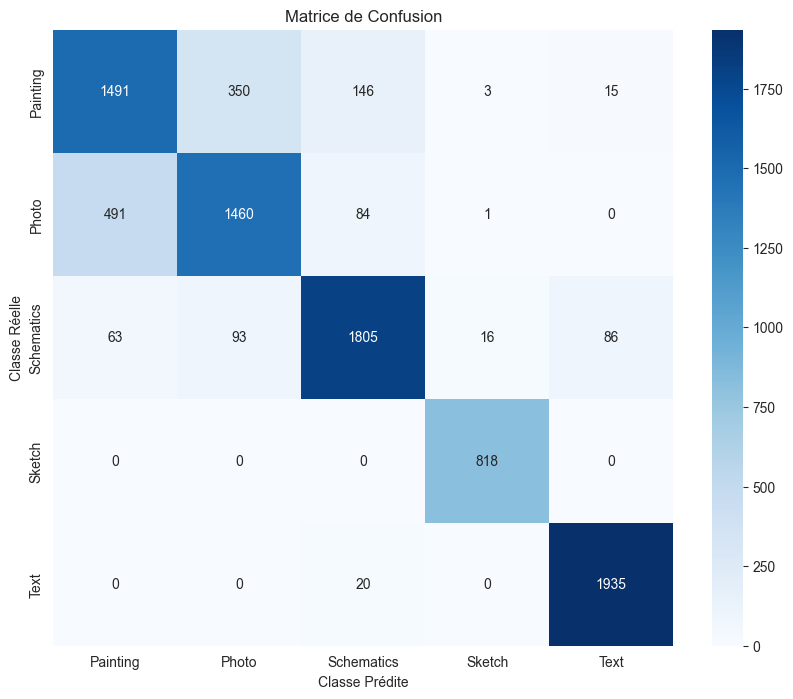

Rapport de Classification :
              precision    recall  f1-score   support

    Painting       0.73      0.74      0.74      2005
       Photo       0.77      0.72      0.74      2036
  Schematics       0.88      0.87      0.88      2063
      Sketch       0.98      1.00      0.99       818
        Text       0.95      0.99      0.97      1955

    accuracy                           0.85      8877
   macro avg       0.86      0.87      0.86      8877
weighted avg       0.84      0.85      0.84      8877



In [17]:
confusion_matrix_and_report(model, val_set, class_names)